## Ocean Surface Mixed Layer Depths

This notebook plots the global distribution of surface mixed layer depths

In [1]:
import os

In [2]:
MLD='EN'

config = {
    "startyr": "2003",
    "endyr": "2017",
#     #"dora_id": "odiv-231", #CM4x p25 historical
#     #"dora_id": "odiv-232", #CM4x p25 SSP585
#     # "dora_id": "odiv-255", #CM4x p125 historical
#     #"dora_id": "odiv-293", #CM4x p125 SSP585
    #"dora_id": "odiv-280", #OM4
    #"dora_id": "odiv-269", #b00
    #"dora_id": "odiv-290", #b01 = b00 +dT cpld
    #"dora_id": "odiv-301", #b02
    #"dora_id": "odiv-319", #b03
    #"dora_id": "odiv-338", #b03+nB
    #"dora_id": "odiv-385", #b04
    #"dora_id": "odiv-384", #b05
    #"dora_id": "odiv-391", #b05+nArc
    #"dora_id": "odiv-393", #b05+nB
    #"dora_id": "odiv-395", #b05+R
    #"dora_id": "odiv-411", #b05+R+nArc
    "dora_id": "odiv-403", #b05+R+nArc+nB
#     #"dora_id": "odiv-356", #b03 new topo
#     #"dora_id": "odiv-319", #b03 old topo
#     # "dora_id": "odiv-238",#Control
#     # "dora_id": "odiv-241",#KV0
#     # "dora_id": "odiv-245",#KSBBL
#     #  "dora_id": "odiv-246",#All
#     # "dora_id": "odiv-247",#MStar
#     #"dora_id": "odiv-368",#MStar
#     #"dora_id": "odiv-371",#MStar
#     "dora_id": "odiv-319",#MStar
#     "pathPP": None,
}

for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"]
        if f"MAR_{k.upper()}" in os.environ.keys()
        else v
)

### Import Python Modules

In [3]:
import xarray as xr
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import copy 
import glob
import subprocess
import doralite
import momgrid as mg
import xesmf as xe

In [4]:
# momgrid will use a directory of pre-computed weights (do I need this?)
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

In [5]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

experiment =  doralite.dora_metadata(config["dora_id"])
pathPP = experiment["pathPP"]
expName = experiment["expName"]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

auto_checkout = False

print(pathPP)

/archive/John.Krasting/fre_om5/FMS2023.01_om5_20240529/om5_b05_nonBouss_Roquet_noHiLatHenyey/gfdl.ncrc5-intel23-prod/pp/


In [6]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_monthly"
static = f"{component}/{component}.static.nc"
varname = "*"

chunk = "monthly_5yr"
filelist = sorted(glob.glob(f"{pathPP}{component}/av/{chunk}/{component}.*.nc", recursive=True))

def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

filelist = [x for x in filelist if is_in_range(x,start,end)]
staticfile = f"{pathPP}/{static}"

_ = [print(x) for x in filelist]

/archive/John.Krasting/fre_om5/FMS2023.01_om5_20240529/om5_b05_nonBouss_Roquet_noHiLatHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.01.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20240529/om5_b05_nonBouss_Roquet_noHiLatHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.02.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20240529/om5_b05_nonBouss_Roquet_noHiLatHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.03.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20240529/om5_b05_nonBouss_Roquet_noHiLatHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.04.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20240529/om5_b05_nonBouss_Roquet_noHiLatHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.05.nc
/archive/John.Krasting/fre_om5/FMS2023.01_om5_20240529/om5_b05_nonBouss_Roquet_noHiLatHenyey/gfdl.ncrc5-i

In [7]:
if not "DORA_EXECUTE" in os.environ.keys():
    subprocess.run(["dmwho"])

MINUTES  USERNAME                  HOST    COMMAND FILES
   46.0  William.Cooke             pp327   dmput      77
   25.8  John.Krasting             pp331   dmput      32
    9.7  Matthew.Harrison          pp071   dmput      19
    2.6  Linjiong.Zhou             an010   dmget       1
    2.6  Linjiong.Zhou             an105   dmget       1
    1.8  Linjiong.Zhou             an012   dmget       1
    1.8  Linjiong.Zhou             an203   dmget       1
    1.1  Linjiong.Zhou             an011   dmget       1
    0.9  Linjiong.Zhou             an206   dmget       1
    0.8  Linjiong.Zhou             an101   dmget       1
    0.8  Linjiong.Zhou             an106   dmget       1
    0.6  Linjiong.Zhou             an102   dmget       1
    0.2  Linjiong.Zhou             an201   dmget       1
    0.2  Ming.Zhao                 pp202   dmget       1
    0.1  Linjiong.Zhou             an105   dmget       1


In [8]:
if not "DORA_EXECUTE" in os.environ.keys():
    cmd = ["dmget"]+filelist+[staticfile]
    
    if auto_checkout:
        print("Calling dmget on files ...")
        _ = subprocess.check_output(cmd)
    else:
        print("Paste to terminal to dmget files ...")
        out_string=''
        for cell in cmd:
            out_string+=' '+cell
        print(out_string)

Paste to terminal to dmget files ...
 dmget /archive/John.Krasting/fre_om5/FMS2023.01_om5_20240529/om5_b05_nonBouss_Roquet_noHiLatHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.01.nc /archive/John.Krasting/fre_om5/FMS2023.01_om5_20240529/om5_b05_nonBouss_Roquet_noHiLatHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.02.nc /archive/John.Krasting/fre_om5/FMS2023.01_om5_20240529/om5_b05_nonBouss_Roquet_noHiLatHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.03.nc /archive/John.Krasting/fre_om5/FMS2023.01_om5_20240529/om5_b05_nonBouss_Roquet_noHiLatHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.04.nc /archive/John.Krasting/fre_om5/FMS2023.01_om5_20240529/om5_b05_nonBouss_Roquet_noHiLatHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.05.nc /archive/John.Krasting/fre_om5/FMS2023.01_om5_20240529/om5_b0

In [9]:

#Specify the grid for analysis
GRID = 'global'
#GRID = 'EqPac' #Equatorial Pacific
#GRID = 'NAtl' #North Atlantic
#GRID='SO' #Southern Ocean
#GRID='NH' #Northern Hemisphere
#GRID='SH' #Southern Hemisphere
#GRID='TRP' #Tropics (global)


In [10]:
ds = momgrid.Gridset(filelist, force_symmetric=False, return_corners=True)
model_type = ds.model
if MLD=='003':
    ds_modeldata = ds.data.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))[['MLD_003','geolon_c','geolat_c','geolon_u','geolat_u','geolon_v','geolat_v']]
else:
    ds_modeldata = ds.data.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))[['MLD_EN1','MLD_EN2','geolon_c','geolat_c','geolon_u','geolat_u','geolon_v','geolat_v']]
ds_modeldata = ds_modeldata.groupby('time.month').mean('time')
static = xr.open_dataset(staticfile)

In [108]:
#This block is where the GRID choice and method are used to set-up various options, 
# including the domain and the colorbar limits.
if GRID=='global':
    Dims = [-240,120,-90,90]
    Central = 0.5*(Dims[0]+Dims[1])
    CLim1_min=[10,60]
    CLim2_min=[-20,20]
    CLim1_max=[10,500]
    CLim2_max=[-100,100]
elif GRID=='SH':
    Dims = [-240,120,-70,0]
    Central = 0.5*(Dims[0]+Dims[1])
    CLim1_min=[10,60]
    CLim2_min=[-20,20]
    CLim1_max=[10,500]
    CLim2_max=[-100,100]
elif GRID=='NH':
    Dims = [-240,120,0,80]
    Central = 0.5*(Dims[0]+Dims[1])
    CLim1_min=[10,60]
    CLim2_min=[-20,20]
    CLim1_max=[10,500]
    CLim2_max=[-100,100]
elif GRID=='TRP':
    Dims = [-240,120,-22.5,22.5]
    Central = 0.5*(Dims[0]+Dims[1])
    CLim1_min=[10,60]
    CLim2_min=[-20,20]
    CLim1_max=[10,500]
    CLim2_max=[-100,100]
elif GRID=='NAtl':
    Dims = [290,380,40,88]
    Central = 0.5*(Dims[0]+Dims[1])
    Central = -60
    CLim1_min=[10,60]
    CLim2_min=[-20,20]
    CLim1_max=[10,500]
    CLim2_max=[-100,100]
elif GRID=='SO':
    Dims = [-240,120,-75,-25]
    Central = 0.5*(Dims[0]+Dims[1])
    Central = -60
    CLim1_min=[10,60]
    CLim2_min=[-20,20]
    CLim1_max=[10,500]
    CLim2_max=[-100,100]
        
Options = {
    'experiment name':expName,
    'Dims':Dims,
    'central':Central,
    'CLim1_min':CLim1_min,
    'CLim2_min':CLim2_min,
    'CLim1_max':CLim1_max,
    'CLim2_max':CLim2_max,
}

In [109]:
#Obs File
if MLD=='003':
    obs_003 = '/net3/bgr/Datasets/Argo/MLDs_v2/Argo_MLD.mld_prho_threshold_003.nc'
    ds_003= xr.open_dataset(obs_003)
    ds_obsdata = xr.Dataset()
    ds_obsdata['lat']=ds_003['Lat'].values
    ds_obsdata['lon']=ds_003['Lon'].values
    ds_obsdata['Month']=ds_003['Month'].values
    ds_obsdata['MLD_003']=(('Month','lon','lat'),ds_003['MLD_mean'].values)
else:
    obs_en1 = '/net3/bgr/Datasets/Argo/MLDs_v2/Argo_MLD.mld_pe_anomaly_25.nc'
    obs_en2 = '/net3/bgr/Datasets/Argo/MLDs_v2/Argo_MLD.mld_pe_anomaly_2500.nc'
    ds_en1= xr.open_dataset(obs_en1)
    ds_en2= xr.open_dataset(obs_en2)
    ds_obsdata = xr.Dataset()
    ds_obsdata['lat']=ds_en1['Lat'].values
    ds_obsdata['lon']=ds_en1['Lon'].values
    ds_obsdata['Month']=ds_en1['Month'].values
    ds_obsdata['MLD_EN1']=(('Month','lon','lat'),ds_en1['MLD_mean'].values)
    ds_obsdata['MLD_EN2']=(('Month','lon','lat'),ds_en2['MLD_mean'].values)

In [110]:
def Set_Plot_ds(cmn_lat,cmn_lon):
    #Using the obs to build the plotting grid
    #Can xarray handle periodic slicing domains?  I'm not sure so adjusting.
    ds_plot = xr.Dataset()
    ds_plot['lat'] = cmn_lat
    ds_plot['lon'] = cmn_lon
    
    return ds_plot

obs_lat = np.copy(ds_obsdata['lat'])
obs_lon = np.copy(ds_obsdata['lon'])
obs_lon[obs_lon<Options['Dims'][0]]+=360
obs_lon[obs_lon>Options['Dims'][1]]-=360
xi = np.argsort(obs_lon)
obs_lon_sort = obs_lon[xi]
lonlims = np.where((obs_lon_sort>Options['Dims'][0])&
                   (obs_lon_sort<Options['Dims'][1]))[0]
latlims = np.where((obs_lat>Options['Dims'][2])&
                   (obs_lat<Options['Dims'][3]))[0]
cmn_lat = obs_lat[latlims]
cmn_lon = obs_lon_sort[lonlims]

ds_min = Set_Plot_ds(cmn_lat,cmn_lon)
ds_max = Set_Plot_ds(cmn_lat,cmn_lon)


model = xr.Dataset()
model["yh"]=ds_modeldata.yh.values
model["xh"]=ds_modeldata.xh.values
if MLD=='003':
    model["MLD_min"]=(('yh','xh'),ds_modeldata.MLD_003.min(dim='month').values)
    model["MLD_max"]=(('yh','xh'),ds_modeldata.MLD_003.max(dim='month').values)
else:
    model["MLD_min"]=(('yh','xh'),ds_modeldata.MLD_EN1.min(dim='month').values)
    model["MLD_max"]=(('yh','xh'),ds_modeldata.MLD_EN2.max(dim='month').values)
model = model.assign_coords(lon=(('yh','xh'),ds_modeldata['geolon'].values))
model = model.assign_coords(lat=(('yh','xh'),ds_modeldata['geolat'].values))


obs = xr.Dataset()
obs['lat']=ds_obsdata['lat'].values
obs['lon']=ds_obsdata['lon'].values
if MLD=='003':
    obs["MLD_min"]=(('lat','lon'),ds_obsdata.MLD_003.min(dim='Month',skipna=False).values.T)
    obs["MLD_max"]=(('lat','lon'),ds_obsdata.MLD_003.max(dim='Month',skipna=False).values.T)
else:
    obs["MLD_min"]=(('lat','lon'),ds_obsdata.MLD_EN1.min(dim='Month',skipna=False).values.T)
    obs["MLD_max"]=(('lat','lon'),ds_obsdata.MLD_EN2.max(dim='Month',skipna=False).values.T)


regridder_mod = xe.Regridder(model, ds_min, "bilinear",periodic=True)

ds_min['model'] = (('lat','lon'),regridder_mod(model.MLD_min.data))
if MLD=='003':
    ds_min['obs'] = (('lat','lon'),((ds_obsdata.MLD_003.min(dim='Month',skipna=False).values.T[:,xi])[latlims[0]:latlims[-1]+1,lonlims[0]:lonlims[-1]+1]))
else:
    ds_min['obs'] = (('lat','lon'),((ds_obsdata.MLD_EN1.min(dim='Month',skipna=False).values.T[:,xi])[latlims[0]:latlims[-1]+1,lonlims[0]:lonlims[-1]+1]))

ds_max['model'] = (('lat','lon'),regridder_mod(model.MLD_max.data))
if MLD=='003':
    ds_max['obs'] = (('lat','lon'),((ds_obsdata.MLD_003.max(dim='Month',skipna=False).values.T[:,xi])[latlims[0]:latlims[-1]+1,lonlims[0]:lonlims[-1]+1]))
else:
    ds_max['obs'] = (('lat','lon'),((ds_obsdata.MLD_EN2.max(dim='Month',skipna=False).values.T[:,xi])[latlims[0]:latlims[-1]+1,lonlims[0]:lonlims[-1]+1]))

def ComputeStats(ds):
    plon,plat = np.meshgrid(ds.lon.values,ds.lat.values)
    Mask = ((np.isfinite(ds.model.values))&(np.isfinite(ds.obs.values))&
           (plon>Options['Dims'][0])&
           (plon<Options['Dims'][1])&
           (plat>Options['Dims'][2])&
           (plat<Options['Dims'][3])
          )
    diff = (ds.model - ds.obs).values
    ds['bias']=np.nansum((diff[Mask]*np.cos(plat[Mask]*np.pi/180.)).ravel())/np.nansum((np.cos(plat[Mask]*np.pi/180.)).ravel())
    ds['RMS'] =np.sqrt(np.nansum((diff[Mask]**2*np.cos(plat[Mask]*np.pi/180.)).ravel())/np.nansum((np.cos(plat[Mask]*np.pi/180.)).ravel()))
    ds['r2']  =np.corrcoef(ds.model.values[Mask].ravel(),ds.obs.values[Mask].ravel())[1,0]**2
    return ds
ds_min = ComputeStats(ds_min)
ds_max = ComputeStats(ds_max)

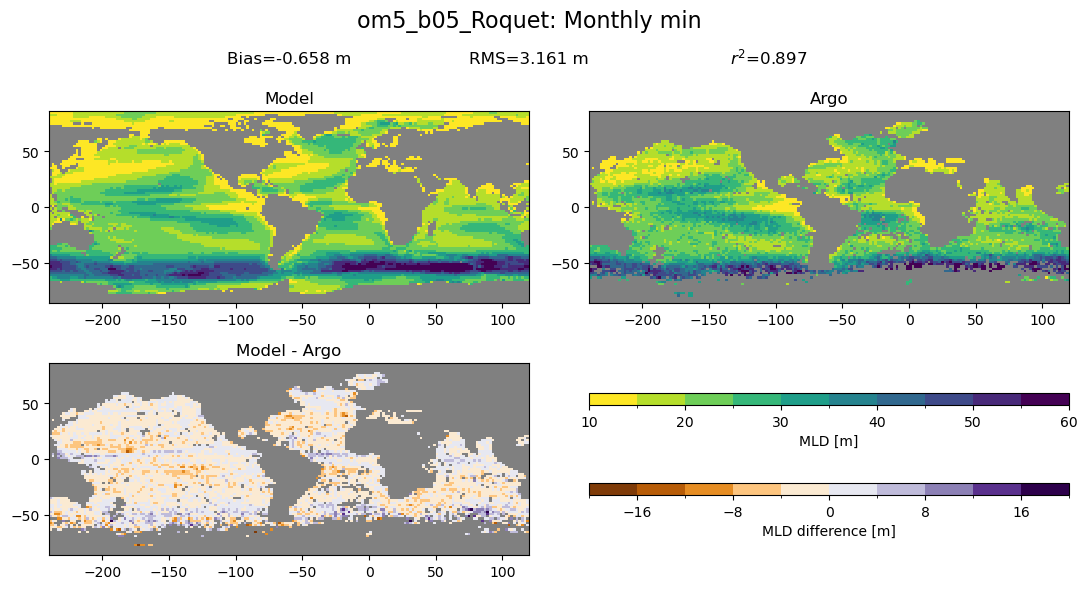

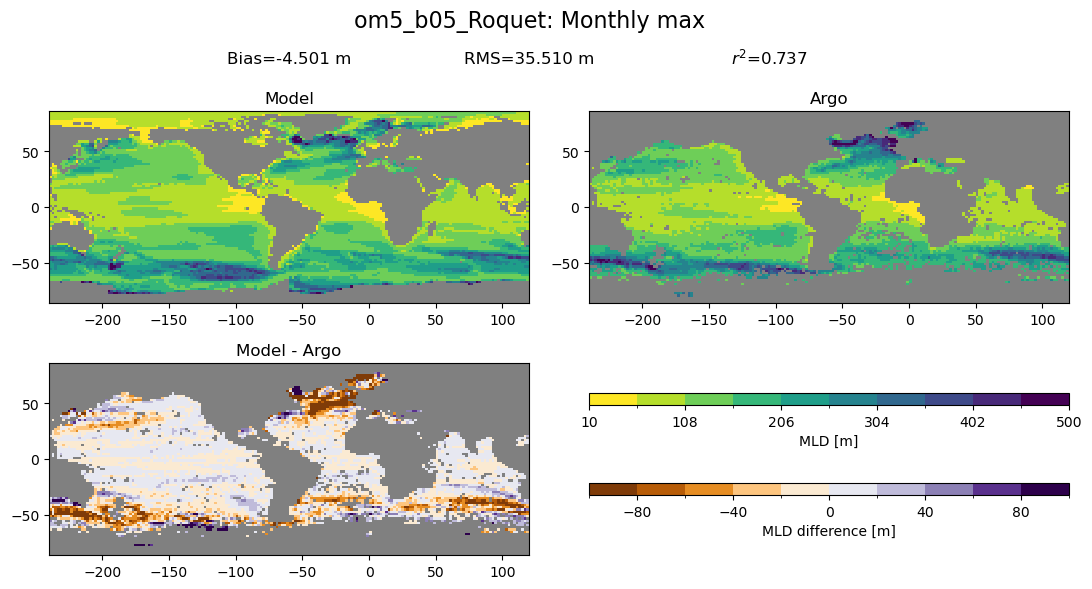

In [111]:
for ds_plot,method in [[ds_min,'min'],
                       [ds_max,'max']
                      ]:
    cmap = copy.copy(plt.cm.viridis_r)
    cmap2 = copy.copy(plt.cm.PuOr)
    cmap.set_bad('gray')
    cmap2.set_bad('gray')
    levels = np.linspace(Options['CLim1_'+method][0],Options['CLim1_'+method][1],11);
    levels2 = np.linspace(Options['CLim2_'+method][0],Options['CLim2_'+method][1],11);
    
    F = plt.figure(figsize=(12, 6))
    lon = ds_plot['lon'].values
    lat = ds_plot['lat'].values
    mod = ds_plot['model'].values
    obs = ds_plot['obs'].values
    dif = mod-obs
    lon,lat = np.meshgrid(lon,lat)
                       
    #ax=F.add_axes([0.1,0.52,0.425,0.32],projection=ccrs.Robinson(central_longitude=Options['central']),facecolor='gray',)
    ax=F.add_axes([0.1,0.52,0.4,0.32])
    cb0 = ax.pcolormesh(lon,
                        lat,
                        mod,
                       shading="auto", 
                       #transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),)
    ax.set_title('Model')
    
    #ax=F.add_axes([0.5,0.52,0.425,0.32],projection=ccrs.Robinson(central_longitude=Options['central']),facecolor='gray')
    ax=F.add_axes([0.55,0.52,0.4,0.32])
    cb1 = ax.pcolormesh(lon,lat,obs,
                       shading="auto", 
                       #transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),)
    ax.set_title('Argo')
    
    #ax=F.add_axes([0.1,0.1,0.425,0.32],projection=ccrs.Robinson(central_longitude=Options['central']),facecolor='gray')
    ax=F.add_axes([0.1,0.1,0.4,0.32])
    cb2 = ax.pcolormesh(lon,lat,dif,
                       shading="auto", 
                       #transform=ccrs.PlateCarree(),
                       cmap=cmap2,
                       norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False),)
    ax.set(title='Model - Argo')
    
    cax1 = F.add_axes([0.55, 0.35, 0.4, 0.02])
    cbar1 = plt.colorbar(cb1,cax=cax1,orientation='horizontal')
    cbar1.set_label('MLD [m]')
    cax2 = F.add_axes([0.55, 0.2, 0.4, 0.02])
    cbar2 = plt.colorbar(cb2,cax=cax2,orientation='horizontal')
    cbar2.set_label('MLD difference [m]')
    
    
    ax = F.add_axes([0.1,0.9,0.8,0.1])
    ax.axis('off')
    ax.set(xlim=(0,1),ylim=(0,1))
    FS=12
    ax.text(0.25,0.2,'Bias={:4.3f} m'.format(ds_plot['bias'].values),fontsize=FS,horizontalalignment='center')
    ax.text(0.5,0.2,'RMS={:4.3f} m'.format(ds_plot['RMS'].values),fontsize=FS,horizontalalignment='center')
    ax.text(0.75,0.2,'$r^2$={:4.3f}'.format(ds_plot['r2'].values),fontsize=FS,horizontalalignment='center')
    FS=16
    ax.text(0.5,0.8,Options['experiment name']+': Monthly '+method,
            fontsize=FS,horizontalalignment='center')